In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
train = pd.read_csv('data/train.csv')
display(train.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.shape

(10886, 12)

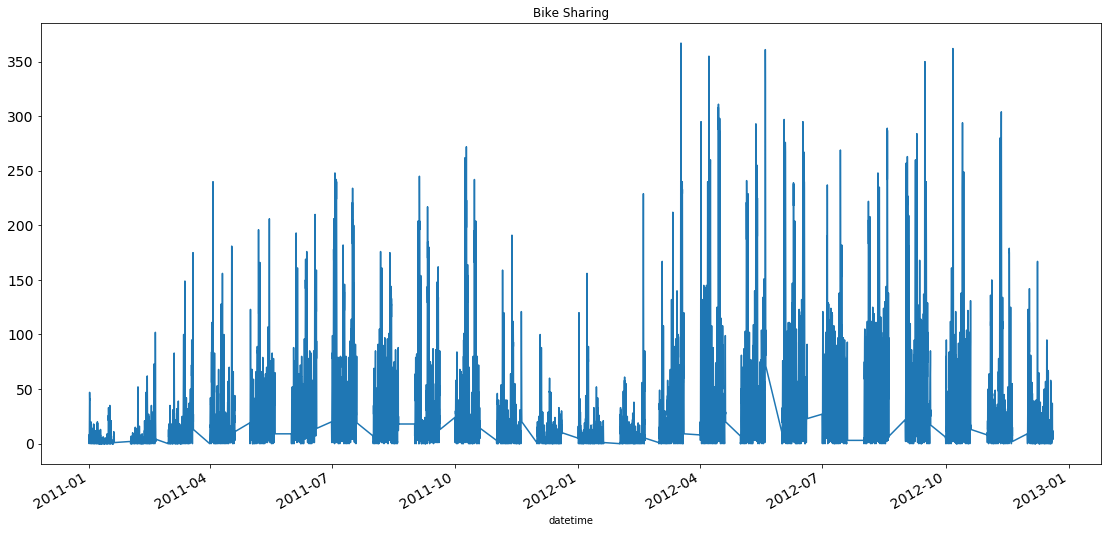

In [7]:
train.datetime = pd.to_datetime(train.datetime)
train.index = train.datetime

train.casual.plot(figsize=(19,9), title="Bike Sharing", fontsize=14)
plt.show()

In [8]:
import seaborn as sns

(11, 11)


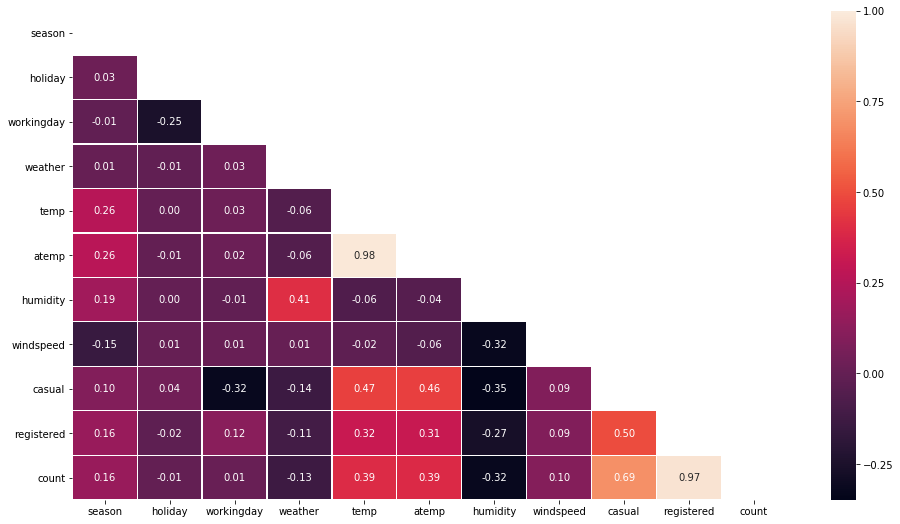

In [11]:
corr = train.corr()
print(corr.shape)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(), annot=True, mask=mask, fmt=".2f", linewidths=.2)
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

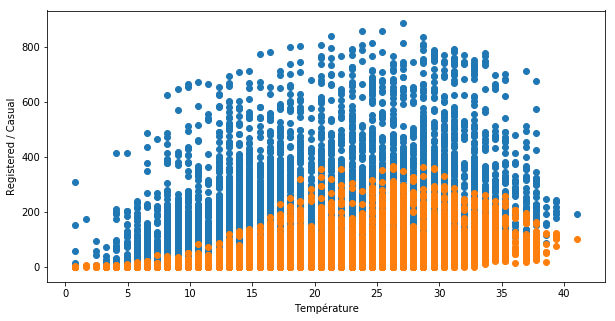

In [8]:
plt.rcParams["figure.figsize"] = [10,5]

plt.scatter(train.temp, train.registered)
plt.scatter(train.temp, train.casual)
plt.ylabel("Casual / Registered")
plt.xlabel("Température")
plt.show()